In [ ]:
import numpy as np

In [ ]:
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Categorical
from pyro.infer.mcmc import MCMC, NUTS
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.abstract_infer import EmpiricalMarginal

## Download fashionMNIST

In [ ]:
def get_mnist_data(train=True):
    mnist_data = datasets.FashionMNIST('../data', train=train, download=True)
    x = mnist_data.data.reshape(-1, 1,28,28).float()
    y = mnist_data.targets
    return x, y

x_train, y_train = get_mnist_data(train=True)
x_test, y_test = get_mnist_data(train=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train, y_train, x_test, y_test = x_train.to(device), y_train.to(device), x_test.to(device), y_test.to(device)

100%|██████████| 26421880/26421880 [00:01<00:00, 17369898.95it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 308578.44it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5496383.66it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19718974.42it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



## Create model

In [ ]:
class My_MLP(nn.Module):
  '''
  Implement a MLP with 3 hidden layers, Tanh activation, no dropout or residual connections
  '''
  def __init__(self, in_dim=1, out_dim=10, hid_dim=200):
    super().__init__()
    assert in_dim > 0
    assert out_dim > 0
    assert hid_dim > 0
    # activation
    # self.act =
    self.act = nn.Tanh()

    #3 hidden layers
    # self.fc1 =
    # self.fc2 =
    # self.fc3 =
    # self.out =
    # raise NotImplemented
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.fc1 = nn.Linear(256, 120)
    self.fc2 = nn.Linear(120, 84)
    #self.fc3 = nn.Linear(200, 84)
    self.out = nn.Linear(84, out_dim)


  def forward(self, x, y=None):
    # raise NotImplemented
    x = self.act(F.max_pool2d(self.conv1(x), 2))
    x = self.act(F.max_pool2d(self.conv2(x), 2))
    x = x.view(-1, self.num_flat_features(x))
    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    #x = self.act(self.fc3(x))
    pred = self.out(x).squeeze()

    return pred

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

### Create probabilistic weights

#### For last layer - quicker to run

In [ ]:
def model(x_data, y_data):
  # raise NotImplemented
  outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight)).to_event(2)
  outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias)).to_event(1)
  priors = {'out.weight': outw_prior, 'out.bias': outb_prior}
  # lift module parameters to random variables sampled from the priors
  lifted_module = pyro.random_module("module", net, priors)
  # sample a regressor (which also samples w and b)
  lifted_reg_model = lifted_module()
  with pyro.plate("data", x_data.shape[0]):
        yhat = softmax(lifted_reg_model(x_data), dim=1)
        obs = pyro.sample("obs", dist.Categorical(yhat), obs=y_data)

In [ ]:
softplus = torch.nn.Softplus()

def my_guide(x_data, y_data):
  # raise NotImplemented
  # Output layer weight distribution priors
  outw_mu_param = pyro.param("outw_mu", torch.randn_like(net.out.weight))
  outw_sigma_param = softplus(pyro.param("outw_sigma", torch.randn_like(net.out.weight)))
  outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).to_event(2)
  # Output layer bias distribution priors
  outb_mu_param = pyro.param("outb_mu", torch.randn_like(net.out.bias))
  outb_sigma_param = softplus(pyro.param("outb_sigma", torch.randn_like(net.out.bias)))
  outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param).to_event(1)

  priors = {'out.weight': outw_prior, 'out.bias': outb_prior}
  lifted_module = pyro.random_module("module", net, priors)
  return lifted_module()

#### For all layers - more accurate

In [ ]:
def model2(x_data, y_data):

    # Prior distributions
    priors = {}
    for i, (name, param) in enumerate(My_MLP().to(device).named_parameters()):
        if i >= 0:
            event_dim = len(param.shape)
            priors[name] = dist.Normal(torch.zeros_like(param), torch.ones_like(param)).to_event(event_dim)

    lifted_module = pyro.random_module("module", My_MLP().to(device), priors)
    lifted_reg_model = lifted_module()
    with pyro.plate("data", x_data.shape[0]):  # Assuming class labels are integers
        logits = lifted_reg_model(x_data)
        logits = softmax(logits, dim=1)
        pyro.sample("obs", dist.Categorical(logits=logits), obs=y_data)

In [ ]:
softplus = torch.nn.Softplus()

def my_guide2(x_data, y_data):

  module = My_MLP().to(device)

  priors = {}
  for name, param in module.named_parameters():
      mu_param = pyro.param(name + '_mu', torch.randn_like(param))
      sigma_param = softplus(pyro.param(name + '_sigma', torch.randn_like(param)))
      event_dim = len(param.shape)
      priors[name] = dist.Normal(loc=mu_param, scale=sigma_param).to_event(event_dim)

  lifted_module = pyro.random_module("module", module, priors)
  return lifted_module()

### Accuracy metrics

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
def get_confusion_matrix(predicted, true):
  return confusion_matrix(np.argmax(true, axis=1), np.argmax(predicted, axis=1))

def get_accuracy(predicted, true):
  return accuracy_score(np.argmax(true, axis=1), np.argmax(predicted, axis=1))

def get_precision(predicted, true):
  return precision_score(np.argmax(true, axis=1), np.argmax(predicted, axis=1), average='weighted')

def get_f1(predicted, true):
  return f1_score(np.argmax(true, axis=1), np.argmax(predicted, axis=1), average='weighted')


### MCMC

In [ ]:
# define model
net = My_MLP().to(device)

In [ ]:
## clear gpu memory on colab
import gc
torch.cuda.empty_cache()
gc.collect()

3968

In [ ]:

# define MCMC sampler
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=50, num_chains=1)

mcmc.run(x_train, y_train)

Warmup:   0%|          | 0/100 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
Sample: 100%|██████████| 100/100 [1:13:41, 44.21s/it, step size=6.21e-03, acc. prob=0.930]


#### MCMC accuracy and trace tests

In [ ]:
from pyro.infer import Predictive


In [ ]:
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds = predictive(x_test, None)['obs']

In [ ]:
preds_np = preds.to("cpu").numpy()

In [ ]:
preds_mean = np.mean(preds_np, axis=0).round().astype(int)

In [ ]:
accuracy_score(y_test.to('cpu'), preds_mean)#, average='weighted')

0.5519

#### Save the MCMC object

In [ ]:
!pip install dill
import dill
# with open('file.pkl', 'wb') as f:
# 	dill.dump(mcmc, f)
with open('file.pkl', 'rb') as f:
	supervised_posterior = dill.load(f)

In [ ]:
mcmc = supervised_posterior

In [ ]:
import arviz as az

#### Plot trace

In [ ]:
posterior_mcmc = mcmc.get_samples()

for x in posterior_mcmc:
  posterior_mcmc[x] = posterior_mcmc[x].to("cpu")

idata = az.from_pyro(mcmc).posterior

/usr/local/lib/python3.10/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'module$$$out.bias'}>,
        <Axes: title={'center': 'module$$$out.bias'}>],
       [<Axes: title={'center': 'module$$$out.weight'}>,
        <Axes: title={'center': 'module$$$out.weight'}>]], dtype=object)

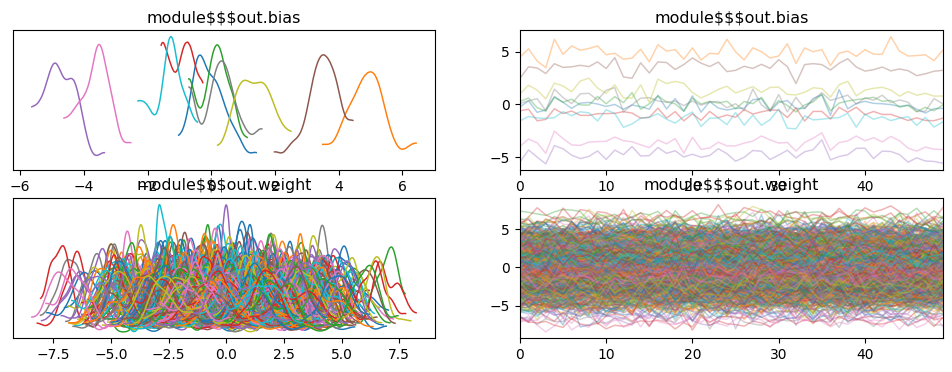

In [ ]:
az.plot_trace(idata, compact=True)

### VI

In [ ]:
net = My_MLP().to(device)

In [ ]:
adam = pyro.optim.Adam({"lr": 1e-3})
# svi = raise NotImplemented
elbo = Trace_ELBO()
svi = SVI(model, my_guide, adam, loss=elbo)

In [ ]:
from tqdm.auto import trange, tqdm

In [ ]:
pyro.clear_param_store()
batch_size = 250
bar = trange(30)
train_loss = []
test_loss = []
weight_trace = []
bias_trace = []
for epoch in bar:
  for batch_idx in range(int(x_train.shape[0] / batch_size)):
    batch_low, batch_high = batch_idx * batch_size, (batch_idx+1) * batch_size
    loss = svi.step(x_train[batch_low:batch_high], y_train[batch_low:batch_high])
    bar.set_postfix(loss=f'{loss / batch_size:.3f}')
    weight_trace.append(pyro.param("outw_mu").to("cpu").detach().clone().numpy())
    bias_trace.append(pyro.param("outb_mu").to("cpu").detach().clone().numpy())
  # with torch.no_grad():  # for logging only
  #     train_loss.append(elbo.loss(model, my_guide, x_train, y_train)) # or average over batch_loss
  #     test_loss.append(elbo.loss(model, my_guide, x_test, y_test))

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


#### VI accuracy and trace tests

/usr/local/lib/python3.10/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'module$$$out.weight'}>,
        <Axes: title={'center': 'module$$$out.weight'}>],
       [<Axes: title={'center': 'module$$$out.bias'}>,
        <Axes: title={'center': 'module$$$out.bias'}>]], dtype=object)

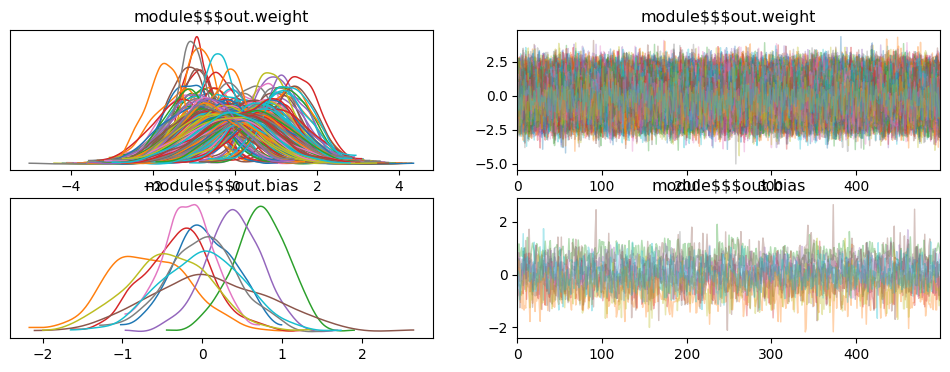

In [ ]:
from pyro.infer import Predictive
predictive = Predictive(model, guide=my_guide, num_samples=500)
preds = predictive(x_test, None)
sanitized_preds = {k: v.unsqueeze(0).to('cpu').detach().numpy() for k, v in preds.items() if k != 'obs'}
pyro_data = az.convert_to_inference_data(sanitized_preds)
az.plot_trace(pyro_data, compact=True)

In [ ]:
num_samples = 10
def predict(x):
    sampled_models = [my_guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return mean
y_preds = predict(x_test).argmax(dim=1)

/usr/local/lib/python3.10/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


In [ ]:
softmax(predict(x_test))

/usr/local/lib/python3.10/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
<ipython-input-19-df2561d07fde>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sum(softmax(predict(x_test))[0])


tensor(1.0000, device='cuda:0')

In [ ]:
def accuracy(targets, predictions):
  return (targets == predictions).sum() / targets.shape[0]

In [ ]:
acc = accuracy(y_test, y_preds)
print("Test accuracy is %.2f%%" % (acc.item() * 100))

Test accuracy is 84.78%


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def avg_over(data, num=5):
  '''
  Calculates average value over a set number
  '''
  data = np.array(data)
  return [np.mean(data[i:i+num]) for i in range(0, len(data), num)]

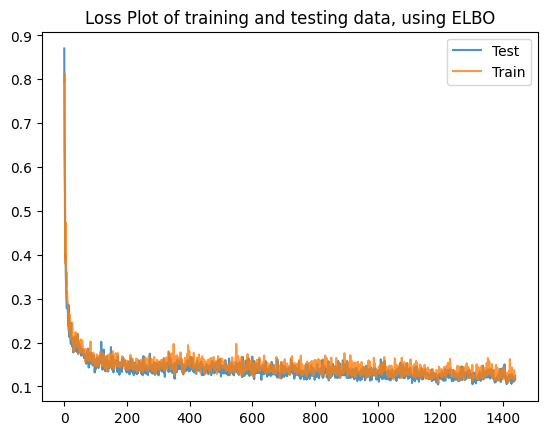

In [ ]:
plt.plot(avg_over(test_loss/np.max(test_loss)), label='Test', alpha=0.8)
plt.plot(avg_over(train_loss/np.max(train_loss)), label='Train', alpha=0.8)
plt.legend()
plt.title("Loss Plot of training and testing data, using ELBO")
plt.show()

In [ ]:
pred = softmax(predict(x_test)).to('cpu')

/usr/local/lib/python3.10/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
<ipython-input-20-e0fb24a93582>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = softmax(predict(x_test)).to('cpu')


In [ ]:
y_test_ohe = torch.nn.functional.one_hot(y_test, 10).to('cpu')

In [ ]:
pic_dict = {0:"Top", 1:"Trouser", 2:"Pullover", 3:"Dress",
            4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker",
            8: "Bag", 9: "Ankle boot"}

In [ ]:
get_f1(pred, y_test_ohe)

0.8440607287661511

In [ ]:
get_precision(pred, y_test_ohe)

0.8459431106517311

In [ ]:
get_accuracy(pred, y_test_ohe)

0.8466

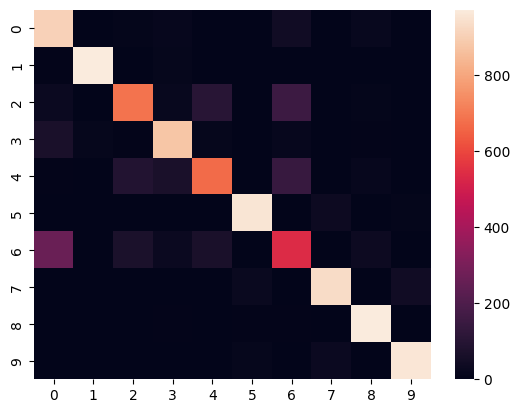

In [ ]:
import seaborn as sns
sns.heatmap(get_confusion_matrix(pred, y_test_ohe))
plt.show()

In [ ]:
# Positions
def get_std(probabilities):
  probabilities = probabilities.numpy()
  min_val = abs(probabilities.min())
  probabilities += min_val
  positions = np.arange(len(probabilities))

  # Calculate mean and standard deviation weighted by probabilities
  weighted_mean_position = np.sum(positions * probabilities)
  std_deviation = np.sqrt(np.sum(probabilities * (positions - weighted_mean_position) ** 2))

  return std_deviation

In [ ]:
pred[0] + abs(pred[0].min())

tensor([1.4882, 0.0000, 3.3059, 2.9468, 0.9226, 4.6092, 3.3549, 4.8940, 0.2836,
        9.2699])

In [ ]:
stds = []
for probs in pred:
  stds.append(get_std(probs))
stds = np.asarray(stds)

In [ ]:
## find mean std for each category
unique_groups = np.unique(np.argmax(y_test_ohe, axis=1))
means = np.array([stds[np.argmax(y_test_ohe, axis=1) == g].mean() for g in unique_groups])

In [ ]:
np.mean(means)

0.880378807016285

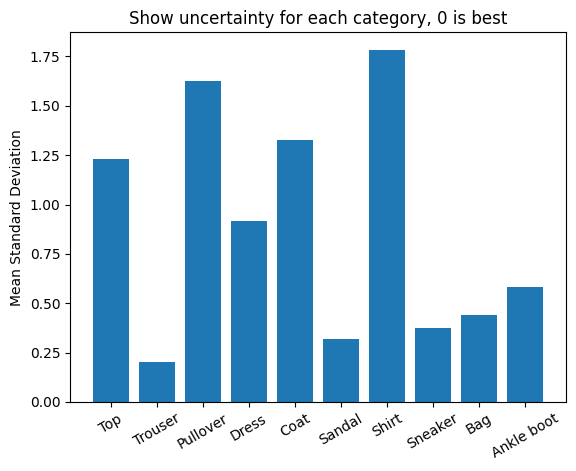

In [ ]:
plt.bar(pic_dict.values(), means)
plt.xticks(rotation=30)
plt.ylabel("Mean Standard Deviation")
plt.title("Show uncertainty for each category, 0 is best")
plt.show()

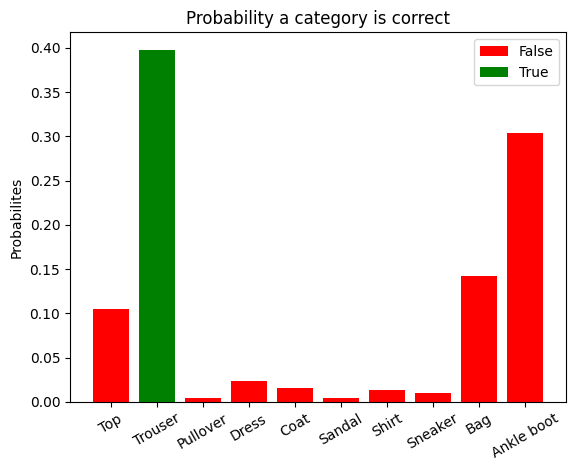

In [ ]:
max_std_pos = np.argmax(stds)
#max_std_pos = 0
plt.bar(pic_dict.values(), pred[max_std_pos], color='red', label='False')
true_pos = np.argmax(y_test_ohe[max_std_pos].numpy())
plt.bar(true_pos, pred[max_std_pos][true_pos], color='green', label='True')
plt.xticks(rotation=30)
plt.ylabel("Probabilites")
plt.title("Probability a category is correct")
plt.legend()
plt.show()